# Predicting Tax Avoidance Categories

## Data Preparation

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
import joblib

from sklearn.model_selection import TimeSeriesSplit, GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, classification_report, ConfusionMatrixDisplay
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.feature_selection import SequentialFeatureSelector

from sklearn import set_config
set_config(enable_metadata_routing=True)


### 1. Load the prepared datasets

In [2]:
train_fe = pd.read_csv('../data/train_fe.csv')
test_fe = pd.read_csv('../data/test_fe.csv')

train_fe.sample(10)
test_fe.sample(10)

train_fe.info()
test_fe.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3993 entries, 0 to 3992
Columns: 116 entries, Unnamed: 0 to cash_holdings_past
dtypes: float64(57), int64(57), object(2)
memory usage: 3.5+ MB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 363 entries, 0 to 362
Columns: 116 entries, Unnamed: 0 to cash_holdings_past
dtypes: float64(57), int64(57), object(2)
memory usage: 329.1+ KB


### 2.Create the target classification variable

In [3]:
def create_target(df):

    bins = [-np.inf, 0.15, 0.25, np.inf]
    labels = [2, 1, 0]

    df_copy = df.copy()
    df_copy['target'] = pd.cut(df_copy['etr'], bins=bins, labels=labels)

    return df_copy


In [4]:
train_fe = create_target(train_fe)
test_fe = create_target(test_fe)
print(train_fe.shape)
print(train_fe.describe())

print("ETR missing: train:", train_fe['etr'].isna().sum(), " / test:", test_fe['etr'].isna().sum())

(3993, 117)
       Unnamed: 0          rok            ta           txt            pi  \
count  3993.00000  3993.000000  3.993000e+03   3993.000000   3993.000000   
mean   2177.00000  2010.000000  2.748262e+04    177.332497    646.508278   
std    1257.62558     3.162674  1.492132e+05    688.278950   2279.888203   
min       0.00000  2005.000000  9.707000e-01  -4432.000000  -9571.000000   
25%    1088.00000  2007.000000  1.995960e+02      1.263000      7.630000   
50%    2177.00000  2010.000000  1.306357e+03     10.295500     57.599998   
75%    3266.00000  2013.000000  8.498754e+03    104.099998    435.479980   
max    4354.00000  2015.000000  2.077758e+06  12737.000000  38834.000000   

               str           xrd             ni         ppent        intant  \
count  3993.000000   3993.000000    3993.000000   3993.000000   3993.000000   
mean      0.230383    276.556515    1623.716504   2023.278564   2157.342155   
std       0.059021   1405.230262    8366.277174   6138.074637   57

### 3. Check class balance and visualize the distribution

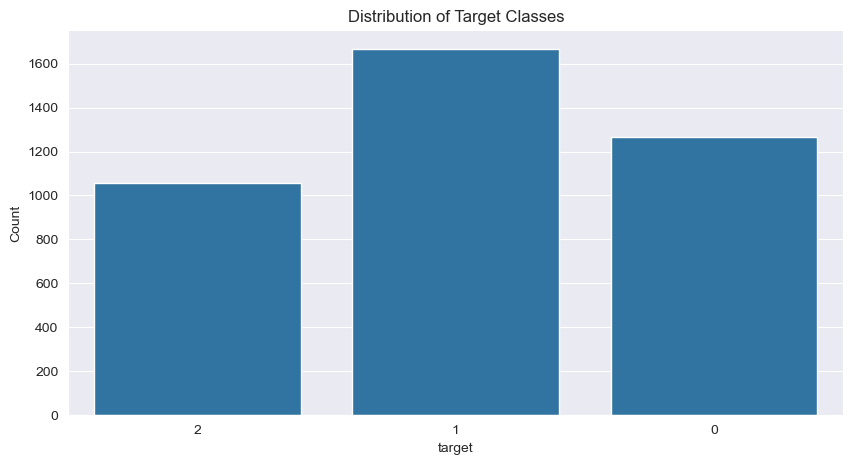

target
1    41.773103
0    31.730528
2    26.496369
Name: proportion, dtype: float64


In [5]:
plt.figure(figsize=(10, 5))
ax = sns.countplot(x='target', data=train_fe)
ax.set(ylabel='Count', title='Distribution of Target Classes')
plt.show()
print(train_fe['target'].value_counts(normalize=True) * 100)

In [6]:
print(train_fe['target'].value_counts(normalize=True) * 100)

target
1    41.773103
0    31.730528
2    26.496369
Name: proportion, dtype: float64


### 4. Select features (use existing feature which already engineered from the project)

In [7]:
print(train_fe.columns)
train_fe

Index(['Unnamed: 0', 'Ticker', 'Nazwa2', 'rok', 'ta', 'txt', 'pi', 'str',
       'xrd', 'ni',
       ...
       'ppe_ma', 'sale_ma', 'cash_holdings_ma', 'roa_past', 'lev_past',
       'intan_past', 'ppe_past', 'sale_past', 'cash_holdings_past', 'target'],
      dtype='object', length=117)


,Unnamed: 0,Ticker,Nazwa2,rok,ta,txt,pi,str,xrd,ni,...,ppe_ma,sale_ma,cash_holdings_ma,roa_past,lev_past,intan_past,ppe_past,sale_past,cash_holdings_past,target
0,0,11B PW Equity,11 bit studios SA,2005,21.127613,1.24185,6.329725,0.19,0.0,5.087900,...,0.013076,0.445954,0.574744,0.240818,0.000000,0.198598,0.013076,0.445954,0.574744,1
1,1,11B PW Equity,11 bit studios SA,2006,21.127613,1.24185,6.329725,0.19,0.0,5.087900,...,0.013076,0.445954,0.574744,0.240818,0.000000,0.198598,0.013076,0.445954,0.574744,1
2,2,11B PW Equity,11 bit studios SA,2007,21.127613,1.24185,6.329725,0.19,0.0,5.087900,...,0.013076,0.445954,0.574744,0.240818,0.000000,0.198598,0.013076,0.445954,0.574744,1
3,3,11B PW Equity,11 bit studios SA,2008,21.127613,1.24185,6.329725,0.19,0.0,5.087900,...,0.013076,0.445954,0.574744,0.240818,0.000000,0.198598,0.013076,0.445954,0.574744,1
4,4,11B PW Equity,11 bit studios SA,2009,21.127613,1.24185,6.329725,0.19,0.0,5.087900,...,0.013076,0.445954,0.574744,0.240818,0.000000,0.198598,0.013076,0.445954,0.574744,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3988,4350,ZMT PW Equity,Zamet Industry SA,2011,203.889008,7.99200,32.415001,0.19,0.0,24.423000,...,0.408827,0.478225,0.213261,0.009109,0.177858,0.079454,0.400440,0.337819,0.171171,1
3989,4351,ZMT PW Equity,Zamet Industry SA,2012,176.524002,7.32400,36.959999,0.19,0.0,29.636000,...,0.385654,0.463679,0.144478,0.119786,0.132538,0.077758,0.370868,0.589539,0.117785,1
3990,4352,ZMT PW Equity,Zamet Industry SA,2013,218.889008,7.08800,36.972000,0.19,0.0,29.884001,...,0.387800,0.631418,0.086577,0.167887,0.081224,0.090118,0.404732,0.673297,0.055369,2
3991,4353,ZMT PW Equity,Zamet Industry SA,2014,264.322998,4.07900,29.132000,0.19,0.0,25.052999,...,0.364668,0.645137,0.032996,0.136526,0.175235,0.075266,0.324603,0.616978,0.010622,1


In [8]:
def sort_df(df):
    return df.sort_values(by=['Ticker', 'rok']).reset_index(drop=True)

train_fe = sort_df(train_fe)
test_fe = sort_df(test_fe)

In [9]:
def select_features(df):
    df.dropna(subset=['target'], inplace=True)
    y = df['target'].astype(int)
    EXCLUDE_FEATURES = ['Unnamed: 0', 'Ticker', 'rok', 'Nazwa2', 'etr', 'target']
    X = df.drop(columns=EXCLUDE_FEATURES, errors='ignore')
    return X, y,

X_train, y_train = select_features(train_fe)
X_test, y_test = select_features(test_fe)

print(f"Train shapes: X={X_train.shape}, y={y_train.shape}")
print(f"Test shapes:  X={X_test.shape}, y={y_test.shape}")

Train shapes: X=(3993, 111), y=(3993,)
Test shapes:  X=(363, 111), y=(363,)


### Identify categorical and numeric features

In [10]:
def identify_feature_types(df):

    numeric_features = df.select_dtypes(include=np.number).columns.tolist()
    categorical_features = df.select_dtypes(include=['object', 'category']).columns.tolist()

    # 数値型だが実質カテゴリな列を移動（閾値は 10）
    low_cardinality_numeric = [col for col in numeric_features if df[col].nunique() <= 10]

    numeric_features = [col for col in numeric_features if col not in low_cardinality_numeric]
    categorical_features.extend(low_cardinality_numeric)

    return numeric_features, list(set(categorical_features))

numeric_cols, categorical_cols = identify_feature_types(X_train)
print(f"Numeric features ({len(numeric_cols)}): {numeric_cols[:5]}...")
print(f"Categorical features ({len(categorical_cols)}): {categorical_cols[:5]}...")

Numeric features (56): ['ta', 'txt', 'pi', 'str', 'xrd']...
Categorical features (55): ['xrd_exists', 'sektor_consumer staples', 'gielda_5', 'dltt_cat_(327.85, 876.617]', 'sektor_utilities']...


### Scaling

In [11]:
numeric_transformer = StandardScaler()
categorical_transformer = OneHotEncoder(handle_unknown='ignore')

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_cols),
        ('cat', categorical_transformer, categorical_cols)
    ],
    remainder='passthrough'
)

## Model Training

In [12]:
tscv = TimeSeriesSplit(n_splits=5)
fitted_models = {}

In [13]:
X_train_transformed = preprocessor.fit_transform(X_train)

total_transformed_features = X_train_transformed.shape[1]
print(f"Transformed feature count (after ColumnTransformer): {total_transformed_features}")


if total_transformed_features > 10:
    n_features_to_select = 10
else:
    n_features_to_select = max(1, int(total_transformed_features * 0.8))

print(f"Will select n_features_to_select = {n_features_to_select} (SFS)")


selector_estimator = LogisticRegression(max_iter=2000, class_weight='balanced', solver='liblinear', random_state=42)

Transformed feature count (after ColumnTransformer): 165
Will select n_features_to_select = 10 (SFS)


### Sequential feature selection

In [14]:
from copy import deepcopy
def make_pipeline_with_sfs(model, cv_obj):

    sfs = SequentialFeatureSelector(
        estimator=deepcopy(selector_estimator),
        n_features_to_select=n_features_to_select,
        direction='forward',
        scoring='f1_macro',
        cv=cv_obj,
        n_jobs=-1
    )

    pipe = Pipeline(steps=[
        ('preprocessor', preprocessor),
        ('feature_selector', sfs),
        ('model', model)
    ])
    return pipe


### Logistic Regression

In [16]:
lr_model = LogisticRegression(random_state=42, max_iter=2000, class_weight='balanced')

lr_params = [
    {'model__solver': ['liblinear'], 'model__penalty': ['l1', 'l2'], 'model__C': [0.1, 1, 10], 'model__max_iter': [2000]},
    {'model__solver': ['saga'], 'model__penalty': ['l1', 'l2'], 'model__C': [0.1, 1, 10], 'model__max_iter': [5000, 10000]}
]

pipeline_lr_tscv = make_pipeline_with_sfs(deepcopy(lr_model), tscv)
gs_lr_tscv = GridSearchCV(pipeline_lr_tscv, lr_params, cv=tscv, scoring='f1_macro', n_jobs=-1, verbose=1)
gs_lr_tscv.fit(X_train, y_train)

fitted_models['Logistic Regression_tscv'] = gs_lr_tscv

print("\n--- Logistic Regression Results ---")

print(f"Best parameters for tscv: {gs_lr_tscv.best_params_}")
print(f"Best CV F1 Macro score for tscv: {gs_lr_tscv.best_score_:.4f}")

Fitting 5 folds for each of 18 candidates, totalling 90 fits

--- Logistic Regression Results ---
Best parameters for tscv: {'model__C': 0.1, 'model__max_iter': 2000, 'model__penalty': 'l1', 'model__solver': 'liblinear'}
Best CV F1 Macro score for tscv: 0.6460


### KNN Classifier

In [ ]:
%%sql


In [17]:
knn_model = KNeighborsClassifier()
knn_params = {
    'model__n_neighbors': [5, 9, 13],
    'model__weights': ['uniform', 'distance'],
    'model__metric': ['minkowski', 'manhattan']
}


pipeline_knn_tscv = make_pipeline_with_sfs(deepcopy(knn_model), tscv)
gs_knn_tscv = GridSearchCV(pipeline_knn_tscv, knn_params, cv=tscv, scoring='f1_macro', n_jobs=-1, verbose=1)
gs_knn_tscv.fit(X_train, y_train)


fitted_models['KNN_tscv'] = gs_knn_tscv

print("\n--- KNN Results ---")

print(f"Best CV F1 Macro score (tscv): {gs_knn_tscv.best_score_:.4f} with params {gs_knn_tscv.best_params_}")

Fitting 5 folds for each of 12 candidates, totalling 60 fits

--- KNN Results ---
Best CV F1 Macro score (tscv): 0.6400 with params {'model__metric': 'minkowski', 'model__n_neighbors': 13, 'model__weights': 'uniform'}


### SVC

In [18]:
svc_model = SVC(random_state=42, class_weight='balanced', probability=True)
svc_params = {
    'model__C': [0.1, 1, 10],
    'model__kernel': ['rbf', 'linear'],
    'model__gamma': ['scale']
}

pipeline_svc_tscv = make_pipeline_with_sfs(deepcopy(svc_model), tscv)
gs_svc_tscv = GridSearchCV(pipeline_svc_tscv, svc_params, cv=tscv, scoring='f1_macro', n_jobs=-1, verbose=2)
gs_svc_tscv.fit(X_train, y_train)


fitted_models['SVC_tscv'] = gs_svc_tscv

print("\n--- SVC Results ---")
print(f"Best CV F1 Macro score (tscv): {gs_svc_tscv.best_score_:.4f} with params {gs_svc_tscv.best_params_}")

Fitting 5 folds for each of 6 candidates, totalling 30 fits
[CV] END model__C=0.1, model__gamma=scale, model__kernel=linear; total time= 1.1min
[CV] END model__C=0.1, model__gamma=scale, model__kernel=rbf; total time= 1.1min
[CV] END model__C=0.1, model__gamma=scale, model__kernel=linear; total time= 1.2min
[CV] END model__C=0.1, model__gamma=scale, model__kernel=rbf; total time= 1.2min
[CV] END model__C=0.1, model__gamma=scale, model__kernel=linear; total time= 1.3min
[CV] END model__C=0.1, model__gamma=scale, model__kernel=rbf; total time= 1.3min
[CV] END model__C=0.1, model__gamma=scale, model__kernel=rbf; total time= 1.4min
[CV] END model__C=0.1, model__gamma=scale, model__kernel=rbf; total time= 1.4min
[CV] END ..model__C=1, model__gamma=scale, model__kernel=rbf; total time= 1.0min
[CV] END ..model__C=1, model__gamma=scale, model__kernel=rbf; total time= 1.1min
[CV] END model__C=0.1, model__gamma=scale, model__kernel=linear; total time= 1.3min
[CV] END model__C=1, model__gamma=sca

### Final Evaluation

### Select the best model based on validation performance

In [19]:
if not fitted_models:
    print("No models have been trained yet. Please run the training cells first.")
else:

    best_model_name = max(fitted_models, key=lambda name: fitted_models[name].best_score_)


    best_model_grid = fitted_models[best_model_name]


    best_model = best_model_grid.best_estimator_

    print(f"✅ Best performing model and CV strategy: {best_model_name}")
    print(f"   - CV F1 Macro Score: {best_model_grid.best_score_:.4f}")
    print(f"   - Best Parameters: {best_model_grid.best_params_}")

✅ Best performing model and CV strategy: Logistic Regression_tscv
   - CV F1 Macro Score: 0.6460
   - Best Parameters: {'model__C': 0.1, 'model__max_iter': 2000, 'model__penalty': 'l1', 'model__solver': 'liblinear'}


### Evaluate on the test set


--- Final Evaluation on Test Set (Logistic Regression_tscv) ---
Accuracy: 0.6061

Classification Report:
                  precision    recall  f1-score   support

   Class 0 (Low)       0.54      0.56      0.55       103
Class 1 (Medium)       0.75      0.65      0.69       195
  Class 2 (High)       0.41      0.55      0.47        65

        accuracy                           0.61       363
       macro avg       0.57      0.59      0.57       363
    weighted avg       0.63      0.61      0.61       363

Confusion Matrix:


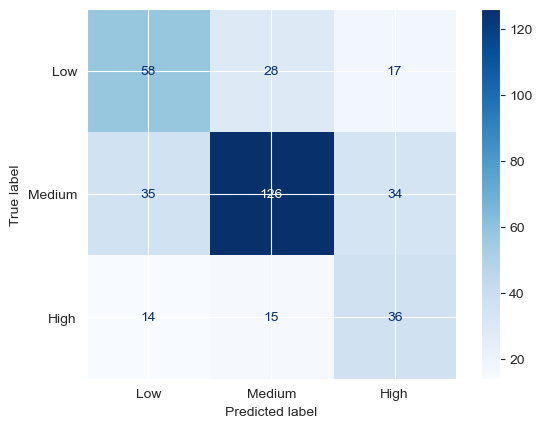

In [20]:
if 'best_model' not in locals():
     print("Best model not selected yet. Please run the selection cell first.")
else:

    y_pred = best_model.predict(X_test)

    print(f"--- Final Evaluation on Test Set ({best_model_name}) ---")

    print(f"Accuracy: {accuracy_score(y_test, y_pred):.4f}\n")

    print("Classification Report:")
    print(classification_report(y_test, y_pred, target_names=['Class 0 (Low)', 'Class 1 (Medium)', 'Class 2 (High)']))

    print("Confusion Matrix:")
    ConfusionMatrixDisplay.from_estimator(best_model, X_test, y_test,
                                          display_labels=['Low', 'Medium', 'High'],
                                          cmap='Blues')
    plt.show()


### Compare results across all three models

In [21]:
if not fitted_models:
    print("No models have been trained yet. Please run the training cells first.")
else:
    results = []

    for name, model_grid in fitted_models.items():
        model_pred = model_grid.predict(X_test)

        results.append({
            'Model & CV Strategy': name,
            'Best CV F1 Macro': model_grid.best_score_,
            'Test Set Accuracy': accuracy_score(y_test, model_pred),
            'Best Params': model_grid.best_params_
        })

    results_df = pd.DataFrame(results).sort_values(by='Best CV F1 Macro', ascending=False)

    print("\n--- Model Comparison Summary ---")
    display(results_df)

    if 'best_model' in locals():
        print("\n--- Saving the Best Model ---")
        os.makedirs('models', exist_ok=True)
        model_filename = f'models/best_{best_model_name.replace(" ", "_").lower()}_model.pkl'
        joblib.dump(best_model, model_filename)
        print(f"Best model ({best_model_name}) saved to: {model_filename}")


--- Model Comparison Summary ---


,Model & CV Strategy,Best CV F1 Macro,Test Set Accuracy,Best Params
0,Logistic Regression_tscv,0.645953,0.606061,"{'model__C': 0.1, 'model__max_iter': 2000, 'mo..."
2,SVC_tscv,0.645466,0.603306,"{'model__C': 10, 'model__gamma': 'scale', 'mod..."
1,KNN_tscv,0.640023,0.586777,"{'model__metric': 'minkowski', 'model__n_neigh..."



--- Saving the Best Model ---
Best model (Logistic Regression_tscv) saved to: models/best_logistic_regression_tscv_model.pkl


## Brief Interpretation

Among the evaluated models, Logistic Regression performed best, achieving the highest cross-validation F1 Macro score of 0.6460. On the final test set, this model proved most effective at identifying the majority 'Medium' avoidance class but struggled significantly with predicting the minority 'High' avoidance class. This suggests that while the model provides a reasonable baseline, its practical ability to flag high-risk cases is limited, likely due to class imbalance, and would require further refinement.